<a href="https://colab.research.google.com/github/Nirupama-b/Low-Dose-CT-Scan-NRIQA-and-Enhancement-/blob/main/SVR_MLP_ImportantFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVR **MODEL**

SVR LATEST (GRID SEARCH) WITH PKL

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr

# Check if model is saved and load it, otherwise train it
try:
    best_svr_model = joblib.load('/content/svr_model.pkl')
    print("Model loaded from /content/svr_model.pkl")
except:
    # Load dataset
    file_path = '/content/features_50.csv'
    data = pd.read_csv(file_path)

    # Drop the 'filename' column
    X = data.drop(columns=['filename', 'quality_score'])
    y = data['quality_score']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 0.01, 0.1, 1]
    }

    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', verbose=0)
    grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_svr_model = grid_search.best_estimator_

    # Save the model
    joblib.dump(best_svr_model, '/content/svr_model.pkl')
    print("Model saved to /content/svr_model.pkl")

# Model evaluation (same as before)
y_pred = best_svr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)
cv_scores = cross_val_score(best_svr_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Display results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")

# Save metrics
metrics = {
    'MSE': mse,
    'R2': r2,
    'MAE': mae,
    'RMSE': rmse,
    'MedAE': medae,
    'Explained Variance': ev_score,
    'Pearson Corr': pearson_corr,
    'Spearman Corr': srocc,
    'Kendall Corr': klcc,
    'Cross-validated R2': cv_scores.mean()
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('/content/model_metrics.csv', index=False)
print("Metrics saved to /content/model_metrics.csv")

# Proceed with the validation set
valid_data = pd.read_csv("/content/valid50.csv")
X_valid = valid_data.drop(columns=['filename', 'quality_score'])
y_valid = valid_data['quality_score']
X_valid = X_valid[X_train.columns]
X_valid_scaled = scaler.transform(X_valid)
y_pred_valid = best_svr_model.predict(X_valid_scaled)
y_pred_valid_rounded = np.round(y_pred_valid, 2)
predictions_df = pd.DataFrame({
    'filename': valid_data['filename'],
    'predicted_quality_score': y_pred_valid_rounded
})
predictions_save_path = "/content/predictions_valid_50_SVR.csv"
predictions_df.to_csv(predictions_save_path, index=False)
print(f"Predictions saved to {predictions_save_path}")


Model saved to /content/svr_model.pkl
Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Squared Error (MSE): 0.0673
R-squared: 0.9383
Mean Absolute Error (MAE): 0.2081
Root Mean Squared Error (RMSE): 0.2594
Median Absolute Error: 0.1679
Explained Variance Score: 0.9383
Pearson Correlation Coefficient: 0.9690
Spearman Rank Correlation Coefficient (SROCC): 0.9678
Kendall Rank Correlation Coefficient (KLCC): 0.8662
Cross-validated R2 scores: [0.93370764 0.93891265 0.93717128 0.94904579 0.94792437]
Mean CV R2 score: 0.9414
Metrics saved to /content/model_metrics.csv
Predictions saved to /content/predictions_valid_50_SVR.csv


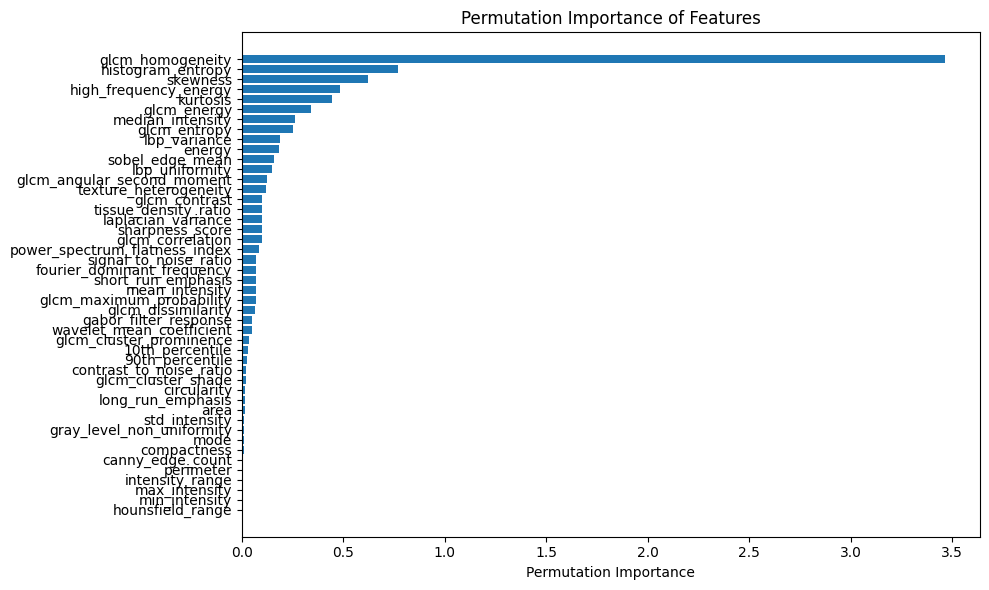

Permutation Importance saved to /content/permutation_importance.csv


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance
perm_importance = permutation_importance(best_svr_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Sort and display the feature importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

# Save permutation importance values
perm_importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_idx],
    'Importance': perm_importance.importances_mean[sorted_idx]
})
perm_importance_df.to_csv("/content/permutation_importance.csv", index=False)
print("Permutation Importance saved to /content/permutation_importance.csv")


PermutationExplainer explainer: 201it [10:08,  3.07s/it]


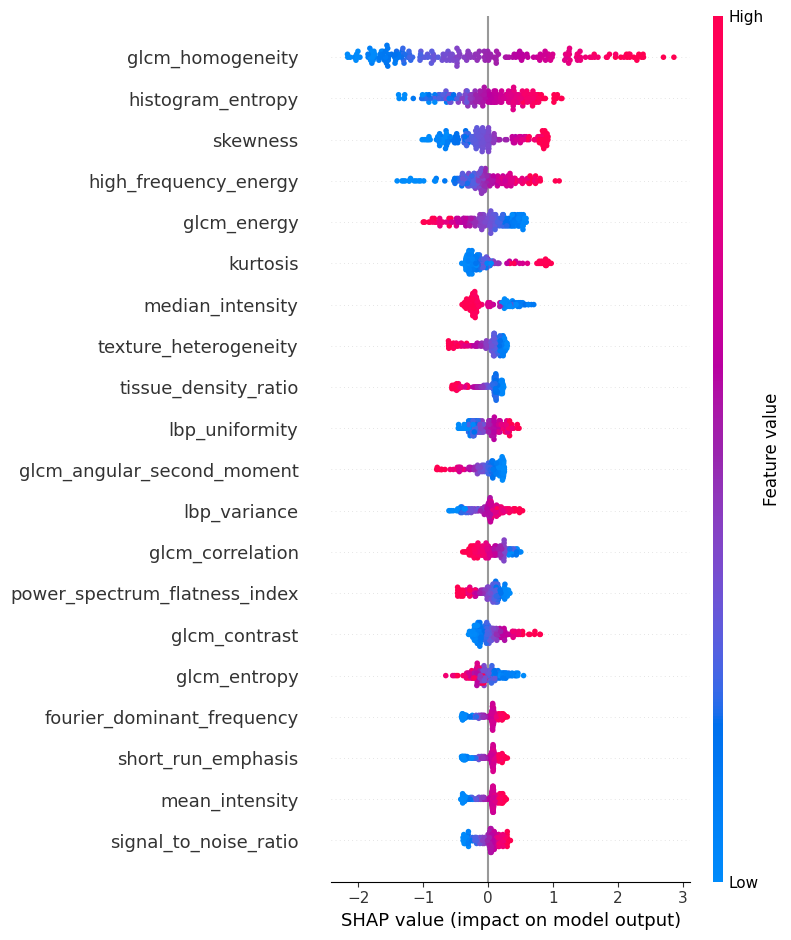

SHAP values saved to /content/shap_values.csv


In [ ]:
import shap

# Use a kernel explainer (suitable for SVR)
explainer = shap.Explainer(best_svr_model.predict, X_test_scaled)
shap_values = explainer(X_test_scaled)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Save SHAP values
shap_values_array = shap_values.values
shap_df = pd.DataFrame(shap_values_array, columns=X.columns)
shap_df.to_csv("/content/shap_values.csv", index=False)
print("SHAP values saved to /content/shap_values.csv")


SVR BEST WITHOUT PKL

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr

# Load dataset
file_path = '/content/features_50.csv'  # Update with correct path if needed
data = pd.read_csv(file_path)



# Drop the 'filename' column
X = data.drop(columns=['filename', 'quality_score'])  # Drop non-feature columns
y = data['quality_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_poly = X_train_scaled
X_test_poly = X_test_scaled

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', verbose=0)  # Set verbose to 0
grid_search.fit(X_train_poly, y_train)

# Best model
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(X_test_poly)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(best_svr_model, X_train_poly, y_train, cv=5, scoring='r2')

# Display results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")

# Load the validation dataset
valid_data = pd.read_csv("/content/valid50.csv")

# Extract features and target using consistent format
X_valid = valid_data.drop(columns=['filename', 'quality_score'])  # Drop non-feature columns
y_valid = valid_data['quality_score']  # Target (quality score)

# Ensure column order matches training set
X_valid = X_valid[X_train.columns]  # Reorder columns to match training set

# Apply scaling and polynomial transformation to validation dataset
X_valid_scaled = scaler.transform(X_valid)  # Use the scaler from training
X_valid_poly = X_valid_scaled  # Use the polynomial transformer

# Predict on the transformed validation set
y_pred_valid = best_svr_model.predict(X_valid_poly)

# Round predictions to two decimal places
y_pred_valid_rounded = np.round(y_pred_valid, 2)

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'filename': valid_data['filename'],  # Retain filenames from the validation data
    'predicted_quality_score': y_pred_valid_rounded
})

# Save predictions to a CSV file
predictions_save_path = "/content/predictions_valid_50_SVR.csv"
predictions_df.to_csv(predictions_save_path, index=False)
print(f"Predictions saved to {predictions_save_path}")

Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Squared Error (MSE): 0.0673
R-squared: 0.9383
Mean Absolute Error (MAE): 0.2081
Root Mean Squared Error (RMSE): 0.2594
Median Absolute Error: 0.1679
Explained Variance Score: 0.9383
Pearson Correlation Coefficient: 0.9690
Spearman Rank Correlation Coefficient (SROCC): 0.9678
Kendall Rank Correlation Coefficient (KLCC): 0.8662
Cross-validated R2 scores: [0.93370764 0.93891265 0.93717128 0.94904579 0.94792437]
Mean CV R2 score: 0.9414


FileNotFoundError: [Errno 2] No such file or directory: '/content/valid50.csv'

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(best_svr_model, X_test_poly, y_test, n_repeats=30, random_state=42, scoring='r2')

# Extract feature names and their importances
feature_names = X.columns
importances = result.importances_mean

# Create a DataFrame to sort and display the top 25 features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display and save the top 25 features
top_25_features_perm = importance_df.head(25)
print("\nTop 25 Most Important Features (Permutation Importance):")
print(top_25_features_perm)

# Save the permutation importance results to a CSV file
top_25_features_perm.to_csv("/content/top_25_features_permutation.csv", index=False)
print("Top 25 features using Permutation Importance saved to '/content/top_25_features_permutation.csv'")



Top 25 Most Important Features (Permutation Importance):
                          Feature  Importance
19               glcm_homogeneity    3.431408
8               histogram_entropy    0.760147
2                        skewness    0.616636
32          high_frequency_energy    0.490747
3                        kurtosis    0.437124
18                    glcm_energy    0.327567
6                median_intensity    0.258959
21                   glcm_entropy    0.253999
9                          energy    0.184752
27                   lbp_variance    0.183704
13                sobel_edge_mean    0.155946
26                 lbp_uniformity    0.144684
45          texture_heterogeneity    0.121125
22     glcm_angular_second_moment    0.119444
44           tissue_density_ratio    0.102142
16                  glcm_contrast    0.101434
17               glcm_correlation    0.097707
43                sharpness_score    0.095457
14             laplacian_variance    0.095457
33  power_spectrum_fla

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(best_svr_model.predict, X_test_poly)
shap_values = explainer(X_test_poly)

# Feature importance summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Extract SHAP feature importance values
shap_feature_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Importance': shap_feature_importance
}).sort_values(by='SHAP Importance', ascending=False)

# Display and save the top 25 features based on SHAP importance
top_25_features_shap = shap_importance_df.head(25)
print("\nTop 25 Most Important Features (SHAP Importance):")
print(top_25_features_shap)

# Save the SHAP importance results to a CSV file
top_25_features_shap.to_csv("/content/top_25_features_shap.csv", index=False)
print("Top 25 features using SHAP saved to '/content/top_25_features_shap.csv'")


NameError: name 'best_svr_model' is not defined

RUNNING WITH TOP 25 FEATURES OF PERMUTATION


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr

# Load the dataset
file_path = '/content/features_50.csv'  # Update if needed
data = pd.read_csv(file_path)

# Drop the 'filename' column and separate target variable
X = data.drop(columns=['filename', 'quality_score'])
y = data['quality_score']

# Load top 25 features from CSV and filter data
top_features_df = pd.read_csv("/content/top_25_features_permutation.csv")  # Adjust path as needed
top_25_features = top_features_df['Feature'].tolist()  # Extract feature names
X_top25 = X[top_25_features]  # Keep only top 25 features

# Split the reduced dataset
X_train_top25, X_test_top25, y_train_top25, y_test_top25 = train_test_split(X_top25, y, test_size=0.2, random_state=42)

# Scaling
scaler_top25 = StandardScaler()
X_train_top25_scaled = scaler_top25.fit_transform(X_train_top25)
X_test_top25_scaled = scaler_top25.transform(X_test_top25)

# Define parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Fit the SVR model with top 25 features
svr_top25 = SVR()
grid_search_top25 = GridSearchCV(svr_top25, param_grid, cv=5, scoring='r2', verbose=0)
grid_search_top25.fit(X_train_top25_scaled, y_train_top25)

# Best model and predictions
best_svr_model_top25 = grid_search_top25.best_estimator_
y_pred_top25 = best_svr_model_top25.predict(X_test_top25_scaled)

# Metrics
mse_top25 = mean_squared_error(y_test_top25, y_pred_top25)
r2_top25 = r2_score(y_test_top25, y_pred_top25)
mae_top25 = mean_absolute_error(y_test_top25, y_pred_top25)
rmse_top25 = np.sqrt(mse_top25)
ev_score_top25 = explained_variance_score(y_test_top25, y_pred_top25)
pearson_corr_top25, _ = pearsonr(y_test_top25, y_pred_top25)
srocc_top25, _ = spearmanr(y_test_top25, y_pred_top25)
klcc_top25, _ = kendalltau(y_test_top25, y_pred_top25)

# Display results
print("\nModel performance with Top 25 Features:")
print(f"Best parameters: {grid_search_top25.best_params_}")
print(f"Mean Squared Error (MSE): {mse_top25:.4f}")
print(f"R-squared: {r2_top25:.4f}")
print(f"Mean Absolute Error (MAE): {mae_top25:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_top25:.4f}")
print(f"Explained Variance Score: {ev_score_top25:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr_top25:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc_top25:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc_top25:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/features_50.csv'

SVR WITH RANDOM SEARCH

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr
import numpy as np

# Load dataset
file_path = '/content/features_50.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Drop unnecessary columns
if 'filename' in data.columns:
    data = data.drop(columns=['filename'])

# Define features and target
X = data.drop(columns=['quality_score'])
y = data['quality_score']

# Display columns for reference
print("Feature columns (X):", X.columns.tolist())
print("Target column (y): quality_score")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'C': [1, 10],  # Reduced for simplicity
    'epsilon': [0.1],  # A single epsilon value for faster search
    'kernel': ['linear', 'rbf'],  # Limited to faster kernels
}

svr = SVR()
random_search = RandomizedSearchCV(svr, param_dist, n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Best model and predictions
best_svr_model = random_search.best_estimator_
y_pred = best_svr_model.predict(X_test_scaled)

# Save predictions to CSV
predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
predictions_file_path = '/content/svr_predictions.csv'
predictions_df.to_csv(predictions_file_path, index=False)
print(f"Predictions saved to {predictions_file_path}")

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(best_svr_model, X_train_scaled, y_train, cv=3, scoring='r2')

# Display results
print(f"Best parameters: {random_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")


Feature columns (X): ['mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'min_intensity', 'max_intensity', 'median_intensity', 'intensity_range', 'histogram_entropy', 'energy', 'mode', '10th_percentile', '90th_percentile', 'sobel_edge_mean', 'laplacian_variance', 'canny_edge_count', 'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity', 'glcm_dissimilarity', 'glcm_entropy', 'glcm_angular_second_moment', 'glcm_cluster_prominence', 'glcm_cluster_shade', 'glcm_maximum_probability', 'lbp_uniformity', 'lbp_variance', 'short_run_emphasis', 'long_run_emphasis', 'gray_level_non_uniformity', 'fourier_dominant_frequency', 'high_frequency_energy', 'power_spectrum_flatness_index', 'wavelet_mean_coefficient', 'gabor_filter_response', 'area', 'perimeter', 'circularity', 'compactness', 'hounsfield_range', 'signal_to_noise_ratio', 'contrast_to_noise_ratio', 'sharpness_score', 'tissue_density_ratio', 'texture_heterogeneity']
Target column (y): quality_score


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Predictions saved to /content/svr_predictions.csv
Best parameters: {'kernel': 'rbf', 'epsilon': 0.1, 'C': 10}
Mean Squared Error (MSE): 0.0717
R-squared: 0.9343
Mean Absolute Error (MAE): 0.2143
Root Mean Squared Error (RMSE): 0.2677
Median Absolute Error: 0.1791
Explained Variance Score: 0.9343
Pearson Correlation Coefficient: 0.9667
Spearman Rank Correlation Coefficient (SROCC): 0.9651
Kendall Rank Correlation Coefficient (KLCC): 0.8600
Cross-validated R2 scores: [0.92457113 0.92916084 0.9364296 ]
Mean CV R2 score: 0.9301


PCA

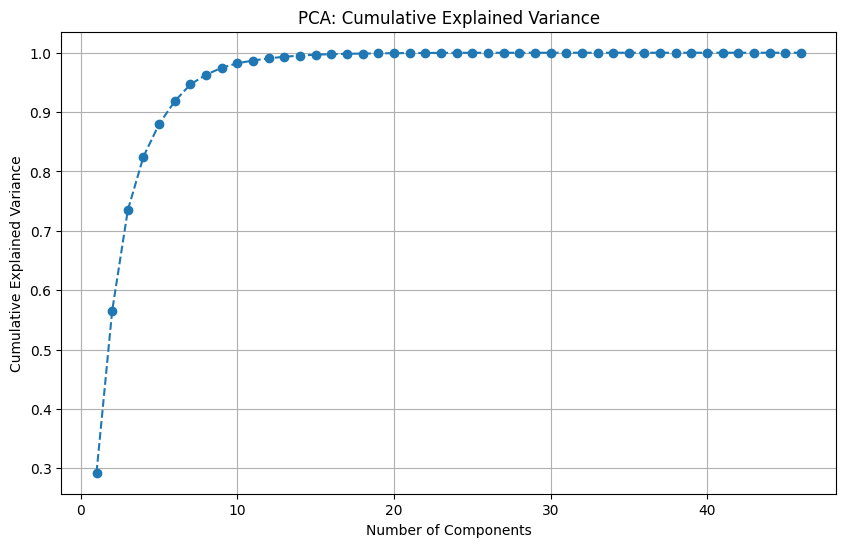

Explained variance ratio for each component:
Principal Component 1: 0.2927
Principal Component 2: 0.2725
Principal Component 3: 0.1697
Principal Component 4: 0.0901
Principal Component 5: 0.0549
Principal Component 6: 0.0385
Principal Component 7: 0.0282
Principal Component 8: 0.0163
Principal Component 9: 0.0118
Principal Component 10: 0.0075
Principal Component 11: 0.0046
Principal Component 12: 0.0037
Principal Component 13: 0.0027
Principal Component 14: 0.0020
Principal Component 15: 0.0015
Principal Component 16: 0.0009
Principal Component 17: 0.0006
Principal Component 18: 0.0004
Principal Component 19: 0.0004
Principal Component 20: 0.0003
Principal Component 21: 0.0002
Principal Component 22: 0.0002
Principal Component 23: 0.0001
Principal Component 24: 0.0001
Principal Component 25: 0.0000
Principal Component 26: 0.0000
Principal Component 27: 0.0000
Principal Component 28: 0.0000
Principal Component 29: 0.0000
Principal Component 30: 0.0000
Principal Component 31: 0.0000
Pri

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
file_path = '/content/features_50.csv'  # Adjust file path if needed
data = pd.read_csv(file_path)

# Define X (features) and drop unnecessary columns
X = data.drop(columns=['filename', 'quality_score'])  # Features
y = data['quality_score']  # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=len(X.columns))  # Start with all components
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Print explained variance for each component
print("Explained variance ratio for each component:")
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {ratio:.4f}")

# Select the top components contributing to 95% variance
optimal_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {optimal_components}")

# Re-run PCA with optimal components
pca_optimal = PCA(n_components=optimal_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Print feature contributions to the first few principal components
for i in range(optimal_components):
    components = pd.Series(pca_optimal.components_[i], index=X.columns)
    print(f"\nTop contributing features for Principal Component {i + 1}:")
    print(components.sort_values(ascending=False).head(10))


PERMUTATION IMPORTANCE

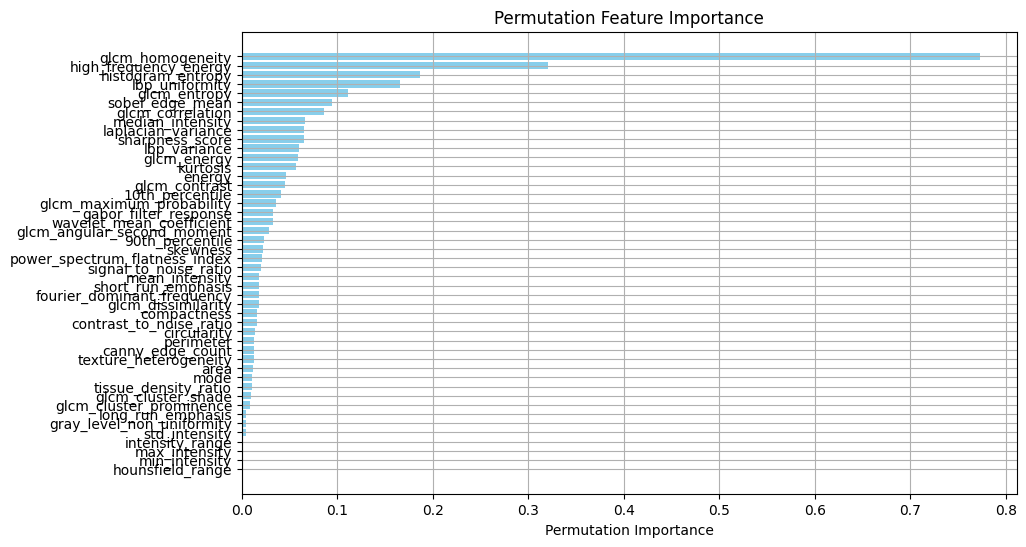

Top 10 important features (Permutation Importance):
glcm_homogeneity: 0.7728
high_frequency_energy: 0.3205
histogram_entropy: 0.1862
lbp_uniformity: 0.1652
glcm_entropy: 0.1113
sobel_edge_mean: 0.0943
glcm_correlation: 0.0863
median_intensity: 0.0659
laplacian_variance: 0.0653
sharpness_score: 0.0653


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance
perm_importance = permutation_importance(best_svr_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importance and sort it
feature_importances = perm_importance.importances_mean
feature_names = X.columns
sorted_idx = feature_importances.argsort()[::-1]

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Print top 10 features
print("Top 10 important features (Permutation Importance):")
for idx in sorted_idx[:10]:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")


SHAP ANALYSIS

  0%|          | 0/200 [00:00<?, ?it/s]

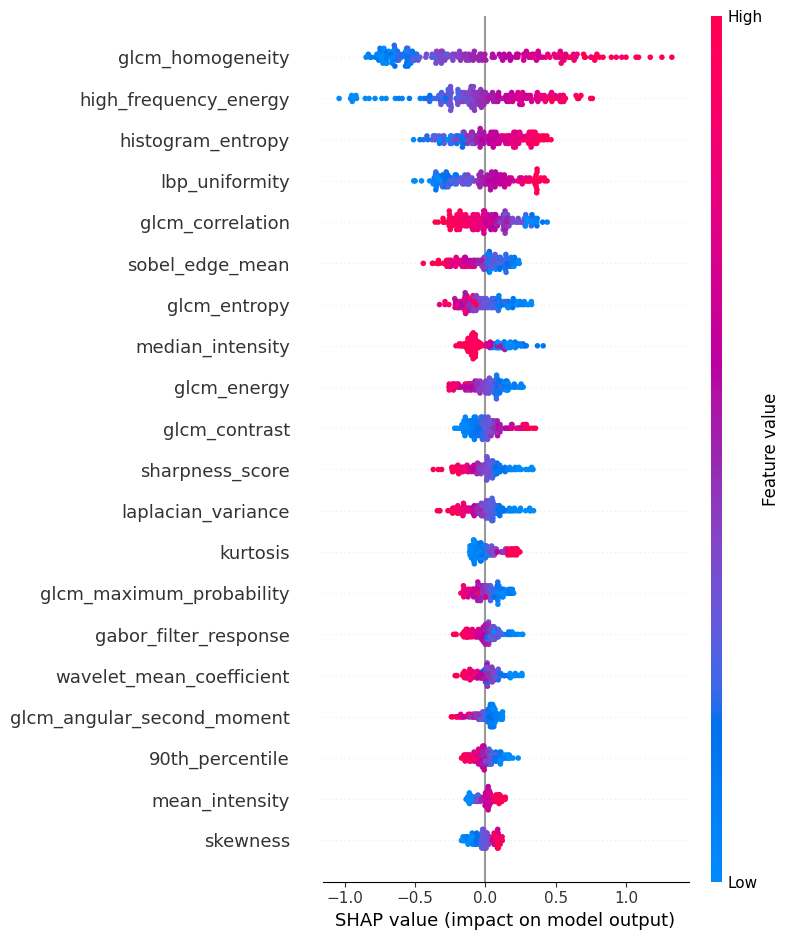

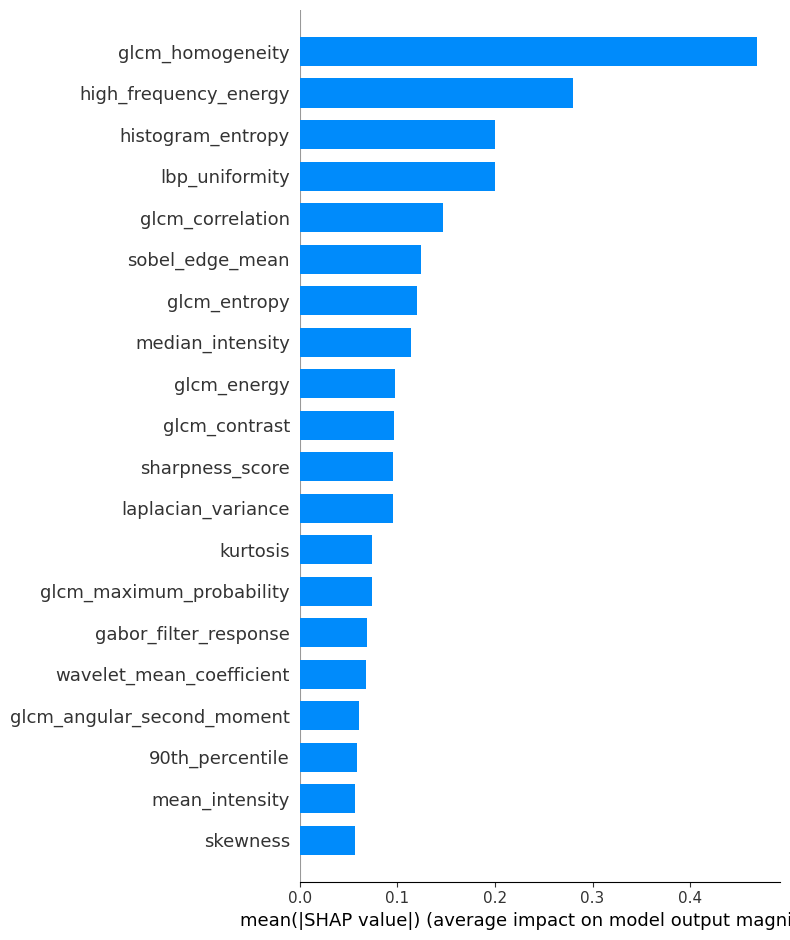

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
!pip install shap

import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
# ... (other imports)

# ... (your code for data loading, preprocessing, and model training)

# Reduce background data size using shap.sample
background_data = shap.sample(X_train_scaled, 100)  # Sample 100 instances

# Train SHAP explainer using the predict method and reduced background data
explainer = shap.KernelExplainer(best_svr_model.predict, background_data)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot to show global feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Bar plot to show mean absolute SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

# Visualize a single prediction
sample_idx = 0  # Change index to visualize different samples
shap.waterfall_plot(shap_values[sample_idx])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr
import numpy as np

# Load dataset
file_path = '/content/features_50.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Drop the 'filename' column if it exists and define X, y
if 'filename' in data.columns:
    data = data.drop(columns=['filename'])

X = data.drop(columns=['quality_score'])  # Drop the non-feature 'quality_score'
y = data['quality_score']  # Target

# Print feature and target columns
print("Feature columns (X):", X.columns.tolist())
print("Target column (y): quality_score")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial feature transformation
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Hyperparameter search space
param_dist = {
    'C': [0.1, 1, 10],  # Reduced values
    'epsilon': [0.01, 0.1, 0.2],  # Smaller range
    'kernel': ['linear', 'rbf'],  # Limited kernels
    'gamma': ['scale', 0.01, 0.1]  # Fewer gamma values
}

# Initialize SVR and RandomizedSearchCV
svr = SVR()
random_search = RandomizedSearchCV(
    svr, param_distributions=param_dist, n_iter=10,  # Limits to 10 random combinations
    cv=5, scoring='r2', verbose=0, n_jobs=-1, random_state=42
)
random_search.fit(X_train_poly, y_train)

# Best model
best_svr_model = random_search.best_estimator_
y_pred = best_svr_model.predict(X_test_poly)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(best_svr_model, X_train_poly, y_train, cv=5, scoring='r2')

# Display results
print(f"Best parameters: {random_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")


Feature columns (X): ['mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'min_intensity', 'max_intensity', 'median_intensity', 'intensity_range', 'histogram_entropy', 'energy', 'mode', '10th_percentile', '90th_percentile', 'sobel_edge_mean', 'laplacian_variance', 'canny_edge_count', 'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity', 'glcm_dissimilarity', 'glcm_entropy', 'glcm_angular_second_moment', 'glcm_cluster_prominence', 'glcm_cluster_shade', 'glcm_maximum_probability', 'lbp_uniformity', 'lbp_variance', 'short_run_emphasis', 'long_run_emphasis', 'gray_level_non_uniformity', 'fourier_dominant_frequency', 'high_frequency_energy', 'power_spectrum_flatness_index', 'wavelet_mean_coefficient', 'gabor_filter_response', 'area', 'perimeter', 'circularity', 'compactness', 'hounsfield_range', 'signal_to_noise_ratio', 'contrast_to_noise_ratio', 'sharpness_score', 'tissue_density_ratio', 'texture_heterogeneity']
Target column (y): quality_score


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr
import numpy as np

# Load dataset
file_path = '/content/features_50.csv'  # Update with correct path if needed
data = pd.read_csv(file_path)

# Define X and y based on column names
X = data.drop(columns=['filename', 'quality_score'])  # Drop non-feature columns
y = data['quality_score']  # Define target

# Print all columns in X and y for reference
print("Feature columns (X):", X.columns.tolist())
print("Target column (y): quality_score")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial feature transformation
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', verbose=0)  # Set verbose to 0
grid_search.fit(X_train_poly, y_train)

# Best model
best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(X_test_poly)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(best_svr_model, X_train_poly, y_train, cv=5, scoring='r2')

# Display results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")


Feature columns (X): ['mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'min_intensity', 'max_intensity', 'median_intensity', 'intensity_range', 'histogram_entropy', 'energy', 'mode', '10th_percentile', '90th_percentile', 'sobel_edge_mean', 'laplacian_variance', 'canny_edge_count', 'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity', 'glcm_dissimilarity', 'glcm_entropy', 'glcm_angular_second_moment', 'glcm_cluster_prominence', 'glcm_cluster_shade', 'glcm_maximum_probability', 'lbp_uniformity', 'lbp_variance', 'short_run_emphasis', 'long_run_emphasis', 'gray_level_non_uniformity', 'fourier_dominant_frequency', 'high_frequency_energy', 'power_spectrum_flatness_index', 'wavelet_mean_coefficient', 'gabor_filter_response', 'area', 'perimeter', 'circularity', 'compactness', 'hounsfield_range', 'signal_to_noise_ratio', 'contrast_to_noise_ratio', 'sharpness_score', 'tissue_density_ratio', 'texture_heterogeneity']
Target column (y): quality_score


KeyboardInterrupt: 


# **NEURAL NETWORK**

1. Model Overview
MLPRegressor is part of a supervised learning approach that uses a feedforward neural network.
It consists of layers of nodes (neurons):
Input Layer: Receives the feature inputs (in this case, X values).
Hidden Layers: Perform computations to learn patterns from the data.
Output Layer: Provides the predicted values (in this case, quality_score).
2. Model Architecture in the Code
Hidden Layers: (64, 32, 16) refers to three layers with 64, 32, and 16 neurons, respectively.
Activation Function: Uses a non-linear activation function (relu by default) to learn complex patterns.
Optimizer: The model uses backpropagation to adjust weights using a solver (learning_rate='adaptive' allows dynamic learning rate adjustments).
Epochs/Iterations: The model trains for a maximum of 1000 iterations (max_iter=1000), or until convergence.
3. How the Model Works
Input Data: The feature set X_train_scaled is passed through the input layer.
Weighted Summation: Each neuron in a layer computes a weighted sum of its inputs and adds a bias term.
Activation Function: Applies an activation function to introduce non-linearity.
Propagation: Outputs from one layer are passed as inputs to the next layer until reaching the output layer.
Error Calculation: The difference between actual and predicted values is used to compute the error.
Backpropagation: Adjusts weights to minimize the error by computing gradients and updating the model.
4. Metrics for Performance Evaluation
The code calculates various metrics to assess model performance:

Mean Squared Error (MSE): Measures average squared differences between actual and predicted values.
R-squared: Indicates the proportion of variance explained by the model.
Mean Absolute Error (MAE): Averages absolute differences between actual and predicted values.
Root Mean Squared Error (RMSE): Square root of MSE, showing error in original units.
Explained Variance Score: Measures how well the model accounts for the variability in data.
Median Absolute Error: Robust measure of prediction accuracy.
Pearson Correlation Coefficient: Measures linear correlation between actual and predicted values.
Spearman Rank Correlation Coefficient (SROCC): Non-parametric measure of rank correlation.
Kendall Rank Correlation Coefficient (KLCC): Measures ordinal association between variables.
Why Use MLPRegressor?
Capability of Learning Complex Non-Linear Relationships: Unlike linear models, neural networks can model intricate patterns in data.
Flexibility: The number of hidden layers and neurons can be tuned to optimize performance.
Generalization: When properly trained, neural networks generalize well to unseen data.
When Is It Useful?
MLPRegressor is well-suited for problems where:

The relationship between input features and output is non-linear.
You have sufficient data for training since neural networks require a significant amount of data to perform well.







In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr, kendalltau, pearsonr
import numpy as np

# Load dataset
file_path = '/content/features_50.csv'
data = pd.read_csv(file_path)

# Define X and y based on column names
X = data.drop(columns=['filename', 'quality_score'])  # Drop non-feature columns
y = data['quality_score']  # Define target

# Print all columns in X and y
print("Feature columns (X):", X.columns.tolist())
print("Target column (y): quality_score")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000, learning_rate='adaptive', random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = mlp_model.predict(X_test_scaled)

# Save predictions to CSV
predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
predictions_file_path = '/content/predictions.csv'
predictions_df.to_csv(predictions_file_path, index=False)
print(f"Predictions saved to {predictions_file_path}")

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_test, y_pred)
ev_score = explained_variance_score(y_test, y_pred)
pearson_corr, _ = pearsonr(y_test, y_pred)
srocc, _ = spearmanr(y_test, y_pred)
klcc, _ = kendalltau(y_test, y_pred)

# Cross-validation (R2 score)
cv_scores = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5, scoring='r2')

# Display results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance Score: {ev_score:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Rank Correlation Coefficient (SROCC): {srocc:.4f}")
print(f"Kendall Rank Correlation Coefficient (KLCC): {klcc:.4f}")
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean CV R2 score: {cv_scores.mean():.4f}")


Feature columns (X): ['mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'min_intensity', 'max_intensity', 'median_intensity', 'intensity_range', 'histogram_entropy', 'energy', 'mode', '10th_percentile', '90th_percentile', 'sobel_edge_mean', 'laplacian_variance', 'canny_edge_count', 'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity', 'glcm_dissimilarity', 'glcm_entropy', 'glcm_angular_second_moment', 'glcm_cluster_prominence', 'glcm_cluster_shade', 'glcm_maximum_probability', 'lbp_uniformity', 'lbp_variance', 'short_run_emphasis', 'long_run_emphasis', 'gray_level_non_uniformity', 'fourier_dominant_frequency', 'high_frequency_energy', 'power_spectrum_flatness_index', 'wavelet_mean_coefficient', 'gabor_filter_response', 'area', 'perimeter', 'circularity', 'compactness', 'hounsfield_range', 'signal_to_noise_ratio', 'contrast_to_noise_ratio', 'sharpness_score', 'tissue_density_ratio', 'texture_heterogeneity']
Target column (y): quality_score
Predictions saved to

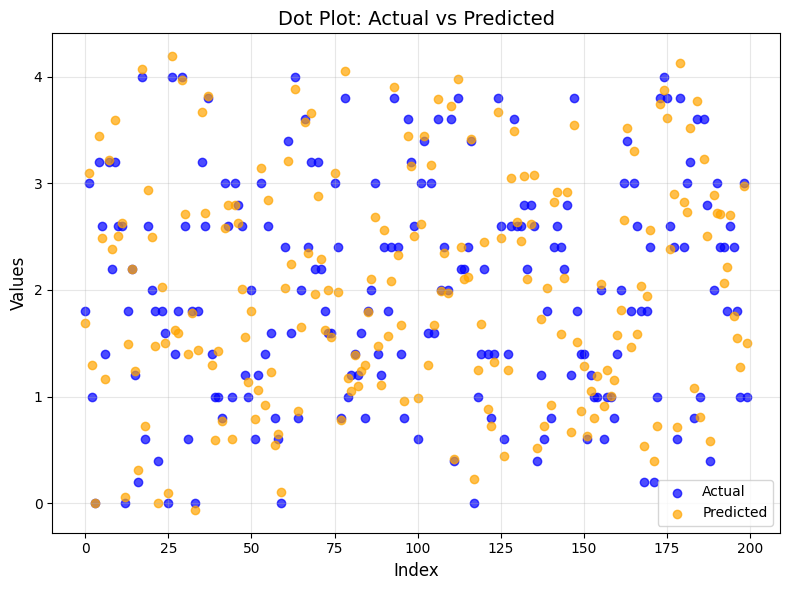

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = '/content/predictions.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Ensure columns for actual and predicted values exist
actual_col = 'Actual'  # Replace with your actual values column name
predicted_col = 'Predicted'  # Replace with your predicted values column name

if actual_col in data.columns and predicted_col in data.columns:
    actual_values = data[actual_col]
    predicted_values = data[predicted_col]
else:
    raise KeyError("Ensure the column names for actual and predicted values are correct in your CSV file.")

# Step 3: Create a dot plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual', alpha=0.7)
plt.scatter(range(len(predicted_values)), predicted_values, color='orange', label='Predicted', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Dot Plot: Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


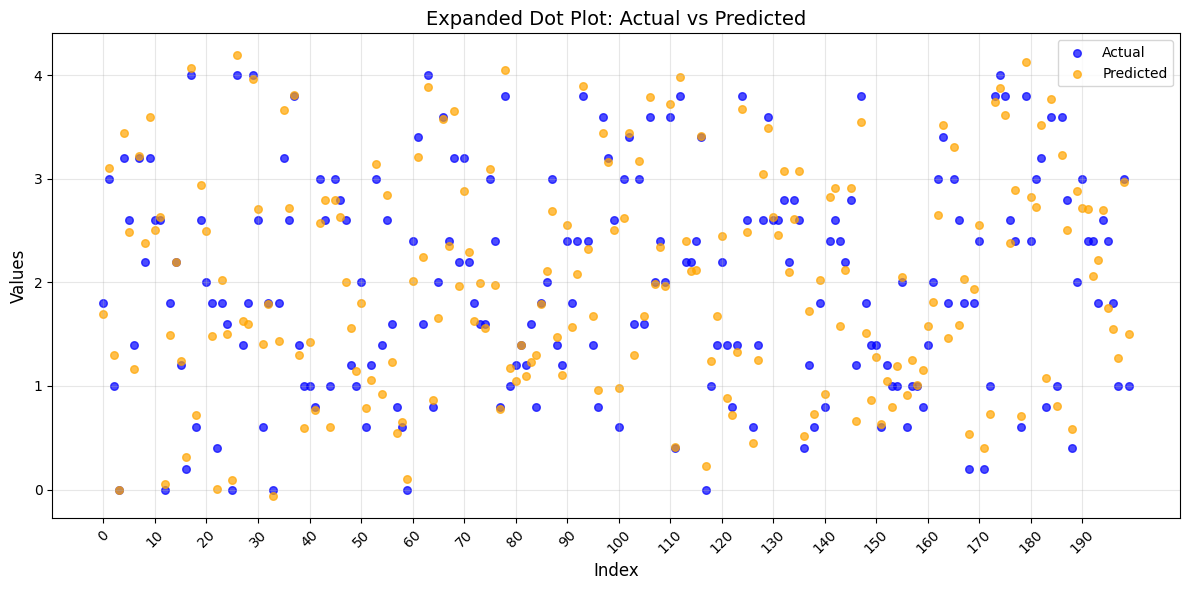

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = '/content/predictions.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Ensure columns for actual and predicted values exist
actual_col = 'Actual'  # Replace with your actual values column name
predicted_col = 'Predicted'  # Replace with your predicted values column name

actual_values = data[actual_col]
predicted_values = data[predicted_col]

# Step 3: Create a dot plot with expanded x-axis
plt.figure(figsize=(12, 6))  # Increase figure width for better spacing
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual', alpha=0.7, s=30)
plt.scatter(range(len(predicted_values)), predicted_values, color='orange', label='Predicted', alpha=0.7, s=30)

# Step 4: Customize x-axis ticks
plt.xticks(ticks=range(0, len(actual_values), max(1, len(actual_values) // 20)), rotation=45, fontsize=10)

# Add labels, legend, and title
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Expanded Dot Plot: Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


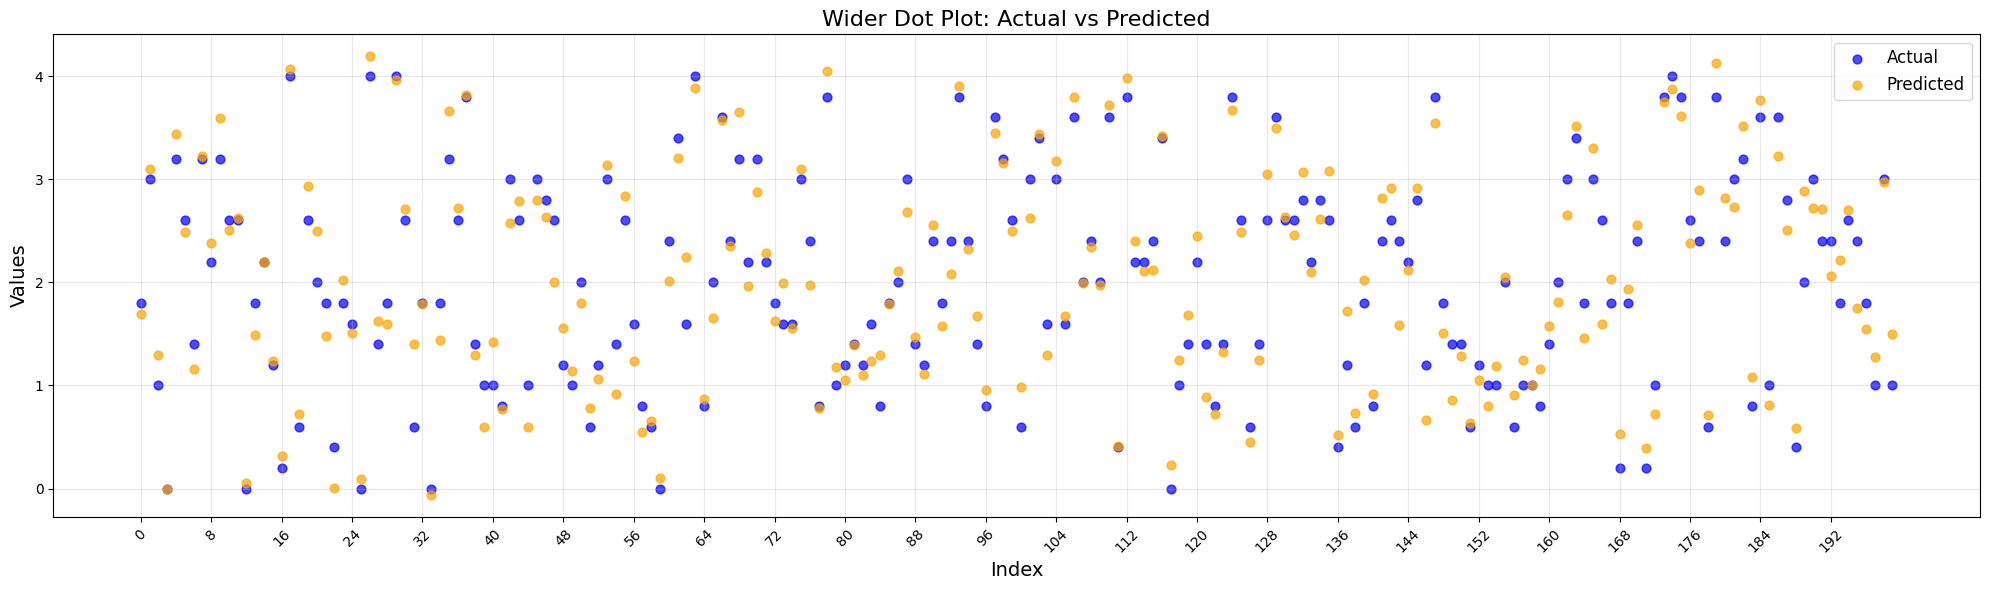

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = '/content/predictions.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Ensure columns for actual and predicted values exist
actual_col = 'Actual'  # Replace with your actual values column name
predicted_col = 'Predicted'  # Replace with your predicted values column name

actual_values = data[actual_col]
predicted_values = data[predicted_col]

# Step 3: Create a wider dot plot
plt.figure(figsize=(20, 6))  # Increase figure width for more spacing
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual', alpha=0.7, s=40)
plt.scatter(range(len(predicted_values)), predicted_values, color='orange', label='Predicted', alpha=0.7, s=40)

# Step 4: Customize x-axis ticks
tick_spacing = max(1, len(actual_values) // 25)  # Dynamic tick spacing based on dataset size
plt.xticks(ticks=range(0, len(actual_values), tick_spacing), rotation=45, fontsize=10)

# Add labels, legend, and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Wider Dot Plot: Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


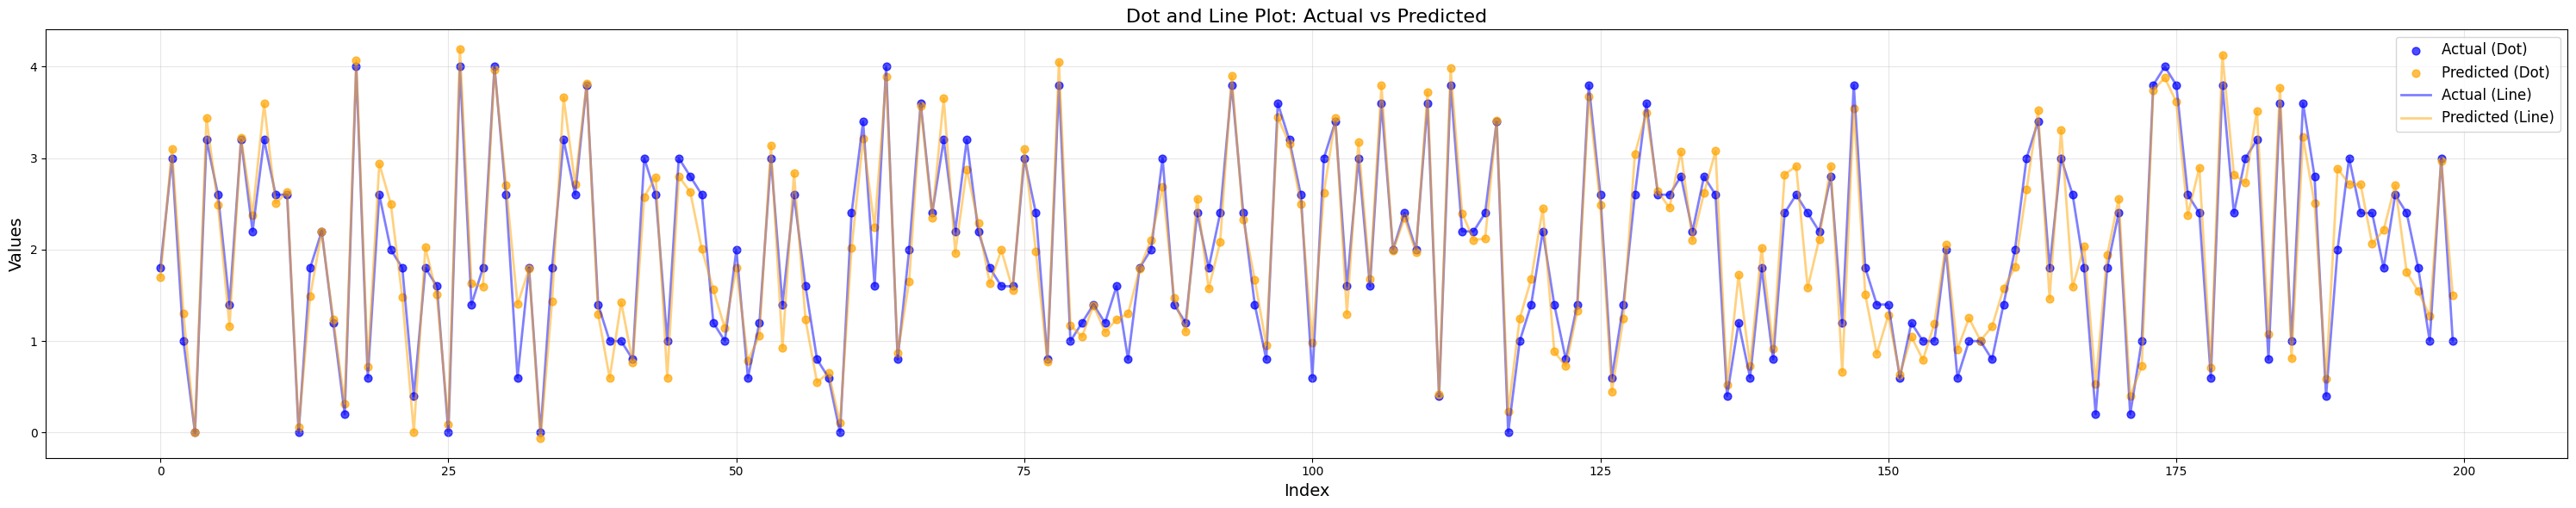

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = '/content/predictions.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Ensure columns for actual and predicted values exist
actual_col = 'Actual'  # Replace with your actual values column name
predicted_col = 'Predicted'  # Replace with your predicted values column name

actual_values = data[actual_col]
predicted_values = data[predicted_col]

# Step 3: Create both dot and line plots
plt.figure(figsize=(30, 6))  # Adjust figure size

# Dot Plot
plt.scatter(range(len(actual_values)), actual_values, color='blue', label='Actual (Dot)', alpha=0.7, s=40)
plt.scatter(range(len(predicted_values)), predicted_values, color='orange', label='Predicted (Dot)', alpha=0.7, s=40)

# Line Plot
plt.plot(actual_values, color='blue', label='Actual (Line)', alpha=0.5, linewidth=2)
plt.plot(predicted_values, color='orange', label='Predicted (Line)', alpha=0.5, linewidth=2)

# Add labels, legend, and title
plt.xlabel('Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Dot and Line Plot: Actual vs Predicted', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


# TOP FEATURES

1. Permutation Importance
Permutation importance involves shuffling individual feature values and measuring the decrease in model performance. It’s model-agnostic and provides a good sense of feature relevance.



In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(mlp_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Display feature importances
importances = result.importances_mean
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print("Top Features by Importance:")
print(feature_importances)

# Save the feature importances to a CSV
feature_importances_file = '/content/feature_importances.csv'
feature_importances.to_csv(feature_importances_file, index=False)
print(f"Feature importances saved to {feature_importances_file}")


Top Features by Importance:
                          Feature  Importance
19               glcm_homogeneity    0.614433
32          high_frequency_energy    0.434430
13                sobel_edge_mean    0.412795
22     glcm_angular_second_moment    0.292353
45          texture_heterogeneity    0.208872
26                 lbp_uniformity    0.191605
18                    glcm_energy    0.163904
8               histogram_entropy    0.163082
0                  mean_intensity    0.161001
43                sharpness_score    0.157994
17               glcm_correlation    0.144263
42        contrast_to_noise_ratio    0.092628
25       glcm_maximum_probability    0.088113
34       wavelet_mean_coefficient    0.087483
23        glcm_cluster_prominence    0.083771
16                  glcm_contrast    0.078528
21                   glcm_entropy    0.072942
36                           area    0.069355
12                90th_percentile    0.064597
38                    circularity    0.063049
14    

2. SHAP (SHapley Additive exPlanations) Values
SHAP values provide detailed feature importance and interpretability by analyzing individual predictions. It’s particularly useful for understanding complex models like neural networks.

In [ ]:
pip install shap

PermutationExplainer explainer: 201it [00:20,  5.67it/s]                         


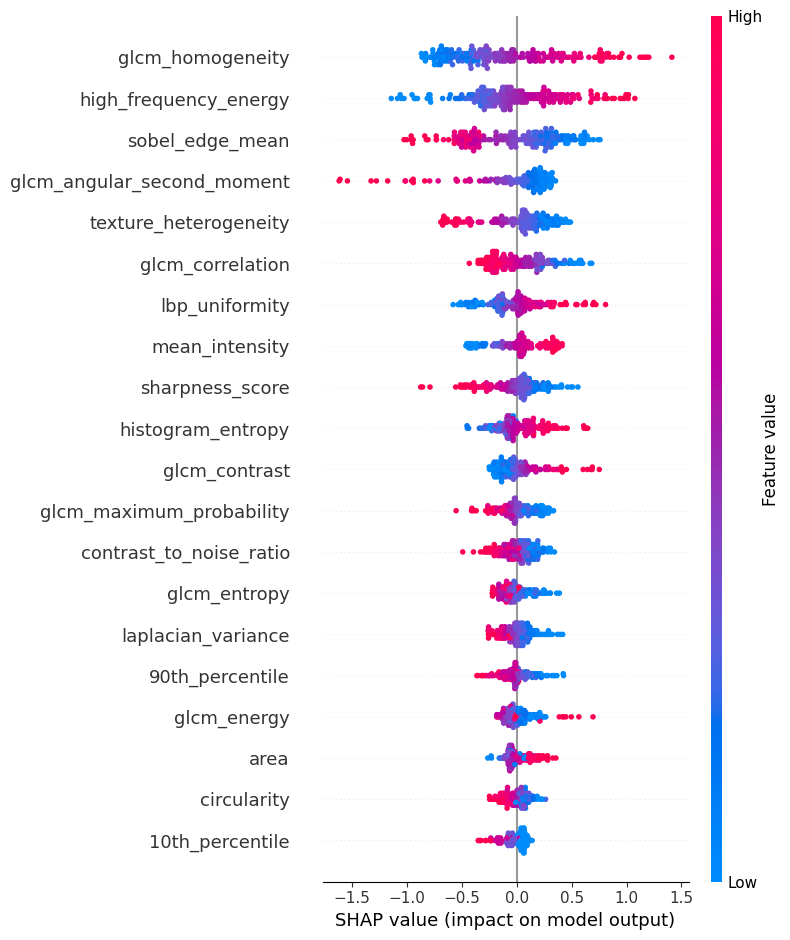

In [ ]:
import shap

# Create a SHAP explainer using the model's predict function
explainer = shap.Explainer(mlp_model.predict, X_train_scaled)  # Use mlp_model.predict
shap_values = explainer(X_test_scaled)

# Plot summary for feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)